# Predicing Asset Price Direction

**Foreword**. This demonstration is a stylised, simplified example of running classifiers (supervised learning) on equity returns. The demo be relevant to CQF Assignment/Examination/one kind of Final Project. For that purpose, is a very starting point. The task is purposefuly limited to prediction of return sign and binomial classification (up/down).

Here, we consider a large-cap equities, however in practice, the high frequency returns of large caps and market indices are the most difficult quantities to predict. Otherwise, the 70-90% traders in CFD accounts would not routinely lose their depostis.

One is more likely to find a sensible scheme in predicting specialised assets and co-movement (spread) rather than returns (prices) of an individual assets. Academic asset pricing theory concerns itself with estimating (prediction) of beta, which is relation between asset returns and the market.

- To organise the prediction (your machine learning workflow) we start with features: generate 7-10 price-related features (columns) and run 'Classifier.fit()' on them. This is no different than running a regression on several variables. For each classifier, you can produce ROC, Confusion Matrix, Transition Probabilities -- the startard evaluation techniques of supervised learning.
- This demo derives features (lagged returns) from the asset price. Price-derived information is limited and there is large discussion about its predictive powers vs. fundamentals, macro economic, and alternative data.

## Improving on price information

However, the forecasting can be technically improved by using the measures of Average and Momentum. You will need to make reasonable choices of time period (rolling window) for SMA, EMA, Momentum. [This link](https://user42.tuxfamily.org/chart/manual/Exponential-Moving-Average.html), gives one example on how to do Exponential Moving Average from the first principles. The choice of smoothing factor $\alpha = \frac{2}{N_{obs} + 1}$.

- Setting up prediction classes, you are likely to encounter the high count of uncertain moves/'no move', where the movement took less than 1/10th of a percentage point.

Remember that for a global market index, the daily average return can be $O(0.04\%)$. $[-1,0,1]$ **trinomial classification** might be more appropriate, but **there is no trading action that follows from the prediction of no move in the asset** (more realistic).

    One but not a universal approach, is to lable 'no moves' as positive. This keeps continuity because most of the moves are positive and we are interested in:

    - 1) isolating information carried by empirical negative returns;
    - 2) better quality in negative market moves prediction.

    The second is because of the assymetry of negative feeling reward for losing money (which one wants to avoid), as compared to the reward for gaining.

Note that we can't simply drop **'no move'** observations from the data because that will our ability to predict for each next trading day -- therefore, P\&L backtesting will be affected.

## NOT Least Squares

This demo is NOT about autoregression analysis in itself. Autoregression is the application of regression on past returns. The regression is essentially an application of a linear model and the method of computation (Maximum Likelihood) involves "the Ordinary Least Squares", $\min_{\hat{\beta}}\sum \epsilon^2_t = (y_t - \hat{\beta} x_t)^2$, hence the abbreviation OLS.

If you formally attempt to use the autogression (or vector autoregression for multiple tickers at the same time) in order to predict the daily return quantity -- you will encounter the forecasting error of 150-200%.

> Example: you are predicting return of -1.5%, the order of error above means that realised return will be anything up to +1.5%, eg 3% absolute difference.

- OLS is NOT a valid regression model for binary dependent variable $0,1$ or for $y_t, x_t$ any *other than Normal variables* (, in other words, OLS works for only normally distributied variables). Strictly speaking OLS is applicable to finanical asset returns (not prices in that price always follows the random walk) and quarterly changes in such variables as GDP and other economic macro.

Change in the nature of dependent variable leads to the change in Maximum Likelhood -- which is 'under the hood' method of how regression works, how regression coefficients are derived and computed. We will consider that today.

Genearalized Linear Models (GLM) is both, extension and the substitution of the linear regression (OLS). It implies a non-linear link function between dependent variable, such as Binary ${0,1}$
 and implied probability $[0.01, \cdots, 0.99]$.

Logistic Regression (Classification) and its Maximum Likelihood -- considered today -- is a good illustration and introduction to the GLM.

We will also demonstrate that prediction results (for asset price direction) that are coming from OLS linear regression are a *fudge*.

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

C:\Users\heidi\AppData\Local\Temp\ipykernel_35008\1188905590.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Generating simple features: lagged returns

In [3]:
data = pd.read_excel('results/20240607_Tut_EquitiesDataGOOG.xlsx', sheet_name="Sheet1", index_col=0, usecols=[0,5])
data.columns = ['price']  # Adj Close Price

In [4]:
data.head()

,price
Date,
2010-10-01,13.076550
2010-10-04,12.995197
2010-10-05,13.390265
2010-10-06,13.293736
2010-10-07,13.185765


<Axes: xlabel='Date'>

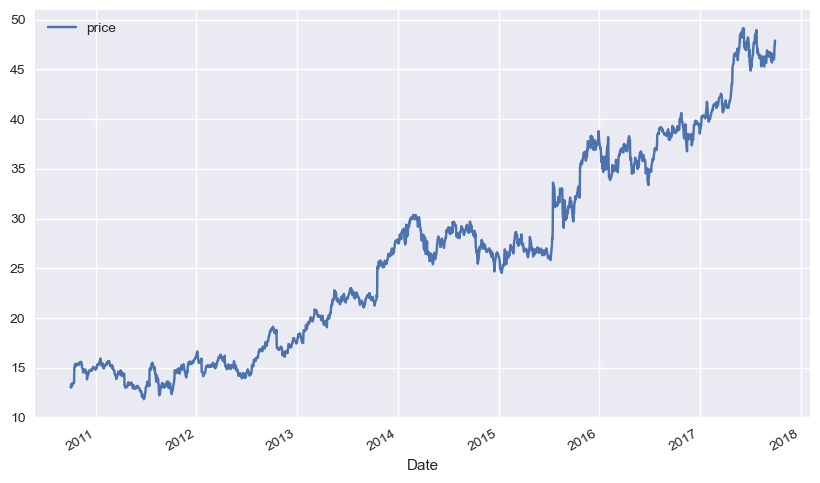

In [5]:
data.plot(figsize=(10, 6))

In [6]:
# SEPARATE for Features Correlation
data_advf = data.copy() #save a copy for advanced look at lagged returns over long term

data_advf['Returns'] = np.log(data_advf).diff()

data_advf.head()

,price,Returns
Date,,
2010-10-01,13.076550,NaN
2010-10-04,12.995197,-0.006241
2010-10-05,13.390265,0.029948
2010-10-06,13.293736,-0.007235
2010-10-07,13.185765,-0.008155


In [7]:
data['return'] = np.log(data / data.shift(1))

In [8]:
data.head()

,price,return
Date,,
2010-10-01,13.076550,NaN
2010-10-04,12.995197,-0.006241
2010-10-05,13.390265,0.029948
2010-10-06,13.293736,-0.007235
2010-10-07,13.185765,-0.008155


In [9]:
lags = 5

cols = []
for lag in range(1, lags+1):
    col = 'ret_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)
    
# Column indexation is from 0, so we effectively have range(1, 6) for returns
# CHECK NOT TO USE Return IN ACTUAL PREDICTION

In [10]:
data.head(10)

,price,return,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,,,
2010-10-01,13.076550,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-04,12.995197,-0.006241,NaN,NaN,NaN,NaN,NaN
2010-10-05,13.390265,0.029948,-0.006241,NaN,NaN,NaN,NaN
2010-10-06,13.293736,-0.007235,0.029948,-0.006241,NaN,NaN,NaN
2010-10-07,13.185765,-0.008155,-0.007235,0.029948,-0.006241,NaN,NaN
2010-10-08,13.343493,0.011891,-0.008155,-0.007235,0.029948,-0.006241,NaN
2010-10-11,13.405441,0.004632,0.011891,-0.008155,-0.007235,0.029948,-0.006241
2010-10-12,13.468882,0.004721,0.004632,0.011891,-0.008155,-0.007235,0.029948
2010-10-13,13.516399,0.003522,0.004721,0.004632,0.011891,-0.008155,-0.007235


In [11]:
data.dropna(inplace=True)

data = data.drop(columns="price")

data['return_sign'] = np.sign(data['return'].values)

data_adv = data.copy() #save a copy for advanced methods (classifiers), as compared to the linear regression

In [12]:
data.head()

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign
Date,,,,,,,
2010-10-11,0.004632,0.011891,-0.008155,-0.007235,0.029948,-0.006241,1.0
2010-10-12,0.004721,0.004632,0.011891,-0.008155,-0.007235,0.029948,1.0
2010-10-13,0.003522,0.004721,0.004632,0.011891,-0.008155,-0.007235,1.0
2010-10-14,-0.004372,0.003522,0.004721,0.004632,0.011891,-0.008155,-1.0
2010-10-15,0.106054,-0.004372,0.003522,0.004721,0.004632,0.011891,1.0


## ASIDE: Correlation in Lagged Returns

In [13]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    data_advf['Ret_'+str(r)] = data_advf.Returns.rolling(r).sum()
    data_advf['Std_'+str(r)] = data_advf.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop NaN values
data_advf.dropna(inplace=True)

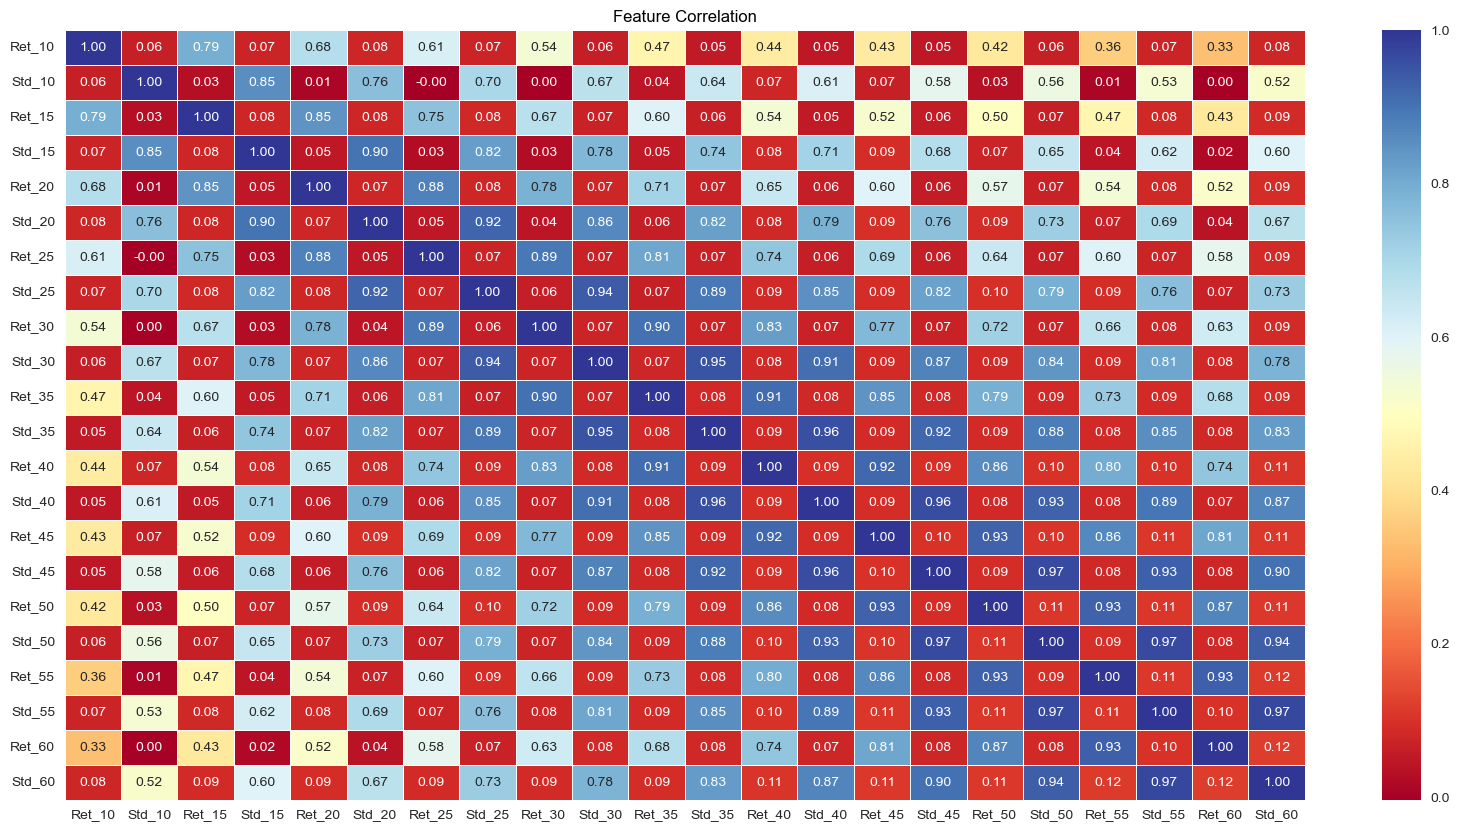

In [14]:
# Derive features correlation
import seaborn as sns
corrmat = data_advf.drop(['price', 'Returns'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap='RdYlBu')
ax.set_title('Feature Correlation', fontsize=12, color='black');

From the correlation figure, we can see clearly, **return** is less correlated with **std**. **Return** or **Std**, however, is correlated with its lag value. Correlation decays as time goes.

---
## 1. Maximum Likelihood for Regression (Ordinary Least Squares)


Maximum Likelihood for Regression (Ordinary Least Squares)

Below work is illustration-only. *Do not run OLS in your assignments and projects*.

When the assumption of Normality of residuals holds: $\epsilon_t$ is *iid* $N(0,\sigma^2)$, the linear regression $y_t = \hat{\beta} x_t + \epsilon_t$ has MLE properties.

That means estimated coefficients $\hat{\beta}$ are

- consistent (i.e., close to unknown true estimates $\beta$ with low tolerance) and
- asymptotically efficient (i.e., their variance is known and minimised).

Estimates $\hat{\beta}$ in fact, maximise the following joint Normal likelihood:

$$ L = \prod_i^T \phi(x_i)$$

$$ L = \bigg(\frac{1}{\sqrt{2\pi \sigma^2}}\bigg)^T exp \Bigg\{ -\frac{1}{2} \bigg[ \frac{\epsilon^2_1}{\sigma^2} + \frac{\epsilon^2_2}{\sigma^2} + \cdots + \frac{\epsilon^2_T}{\sigma^2}  \bigg] \Bigg\} $$

Substituting $\epsilon_t = y_t - \hat{\beta} x_t$ and taking logarithms gives for an individual observation -- I call this quantity a contribution of likelihood from an observation (data row values of features) at time t

$$ \log L_t = -\frac{1}{2}\log 2\pi \sigma^2 - \frac{1}{2} \frac{ (y_t - \hat{\beta}x_t)^2 }{\sigma^2}$$

$$ \log L = \log \prod L_t = \sum \log L_t$$

Total log-likelihood for a regression model is the sum of contributions from each observation $log L = \sum_{t=1}^T L_t$.

Numerical MLE varies $\hat{\beta}$ to maximise $log L$
. This can be done by any non-specific optimisation routine, such as Excel Solver. It is clear to spot that log-likelihood is maximised by **minimising** the residual sum of squares,

$$ RSS = \sum^T_{t=1} \epsilon_t^2 = \sum^T_{t=1} (y_t - \hat{\beta} x_t )^2 $$

Residual sum of squares (RSS) is also known as the sum of squared residuals (SSR) or the sum of squared estimate of errors (SSE).

     CAUTION OLS is an invalid model for binary dependent variable {0, 1}. Think about a change in MLE function for such variable.

The logic behind the following regression is to use previous 5 days return to predict the next following day's one.

In [37]:
# Regression from NUMPY library
reg_coef = np.linalg.lstsq(data[cols].values, data['return_sign'])[0]

# PREFER delegates to use STATSMOTELS
#import statsmodels.api as sm

C:\Users\heidi\AppData\Local\Temp\ipykernel_35008\3882750981.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reg_coef = np.linalg.lstsq(data[cols].values, data['return_sign'])[0]


In [38]:
reg_coef

array([ 1.15631336,  0.36687316, -2.95879533, -0.38949066, -1.38504158])

$$\hat{Y} = X\hat{\beta}$$

In [39]:
data['ols_pred'] = np.sign(np.dot(data[cols].values, reg_coef)) #dot product

In [40]:
data.head(15)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,ols_pred,ols_pred_backtest,ols_pred_move,ols_pred_move_FUDGED,ols_pred_ABSOLUTE
Date,,,,,,,,,,,,
2010-10-11,0.004632,0.011891,-0.008155,-0.007235,0.029948,-0.006241,1.0,1.0,0.004632,0.010403,-0.010403,0.004632
2010-10-12,0.004721,0.004632,0.011891,-0.008155,-0.007235,0.029948,1.0,-1.0,-0.004721,-0.010403,0.010403,-0.004721
2010-10-13,0.003522,0.004721,0.004632,0.011891,-0.008155,-0.007235,1.0,-1.0,-0.003522,-0.010403,0.010403,-0.003522
2010-10-14,-0.004372,0.003522,0.004721,0.004632,0.011891,-0.008155,-1.0,-1.0,0.004372,-0.010403,0.010403,-0.004372
2010-10-15,0.106054,-0.004372,0.003522,0.004721,0.004632,0.011891,1.0,-1.0,-0.106054,-0.010403,0.010403,-0.106054
2010-10-18,0.026676,0.106054,-0.004372,0.003522,0.004721,0.004632,1.0,1.0,0.026676,0.010403,-0.010403,0.026676
2010-10-19,-0.016124,0.026676,0.106054,-0.004372,0.003522,0.004721,-1.0,1.0,-0.016124,0.010403,-0.010403,0.016124
2010-10-20,0.000247,-0.016124,0.026676,0.106054,-0.004372,0.003522,1.0,-1.0,-0.000247,-0.010403,0.010403,-0.000247
2010-10-21,0.006574,0.000247,-0.016124,0.026676,0.106054,-0.004372,1.0,-1.0,-0.006574,-0.010403,0.010403,-0.006574


Count number of predicted moves UP and DOWN

In [41]:
data['ols_pred'].value_counts()

#c.value_counts()[1] / (c.value_counts().sum()) #We were UP this percentage of observations/days

ols_pred
-1.0    939
 1.0    817
Name: count, dtype: int64

**False Negatives -- Type II Error**

The probelm transpires: the model is likely to be bad at predicting negative returns, there are a lot of **false negatives** with -1.0 label.

In terms of generated asset path: in case of bad prediction of negative returns (moves down) we can observe the path drifting downwards and downwards. But that is for later.

---
### 1.1 Vectorised Backtesting = Rebalancing

| 'ols_pred'          | 'return'                    | Result P\&L         |
| ------------------- | --------------------------- | ------------------- |
| NEGATIVE 'ols_pred' | NEGATIVE 'return'           | POSITIVE P\&L       |
| NEGATIVE 'ols_pred' | POSITIVE 'return' (move up) | NEGATIVE P\&L, Loss |
| POSITIVE 'ols_pred' | NEGATIVE 'return'           | NEGATIVE P\&L, Loss |
| POSITIVE 'ols_pred' | POSITIVE 'return' (move up) | POSITIVE P\&L       |

Exercise care with Dr Hilpisch code, particularly on 'vectorised backtesting' where correctly predicted negative sign translates into the Positive P\&L -- that assumes daily rebalancing (betting) rather than replication of the actual asset path.

In [42]:
data['ols_pred_backtest'] = data['return'] * data['ols_pred']

**So above multiplication represents a sequence of daily bets**, based on the sign (up/down move) predicted from past returns.



The actual return that realises today $t$
, is \% P\&L that one makes (loses) on the bet of $100, for example if return today is POSITIVE 0.018 and predcited sign was POSITIVE, then P\&L is 1.18%.

---

$$Return_{pred} = Z^* \times \sigma$$

Assume we want to have more model-like prediction. Then, we will use standard deviation, which gives some measure of randomness.

- We use std dev from the dataset but that can be estimated from any prevoius holdout period/window. Such backtesting requires past data but not regular daily update of return -- the latter is historical backtesting.
- $Z^* = \pm 0.7$ of the standard deviation translates into betting \%70, which is approximately one sigma (68\%) -- the Actual P\&L which would still depend on actual return. But we can plot cumulative P\&L from 'ols_pred_move' to see if matches with the asset path. It also is possible to do P\&L Attribution test on such std dev model:



'ols_pred_move' is in effect, our Theoretical P\&L

'return' is the Actual P\&L

- Why z-score of $\pm 0.7$? This is because empirical asset returns are not well-Normal and between $\pm 2$ standard deviation, but their density/histogram is high-peak (high mode). If you standardise returns $z_T = (r_t - \mu)/\sigma$ the histogram of $z_t$ will have bars within $\pm 0.7$.
- Instead of $\pm 0.7$ and to provide negative outcomes, we can use simulated values of Random Normal
$\phi$ which can be positive or negative.

In [43]:
stdev = data['return'].std()  #from a whole dataset but you can introduce Train/Test split

data['ols_pred_move']        =  0.7 * stdev * ( data['ols_pred'])
data['ols_pred_move_FUDGED'] =  0.7 * stdev * ( - data['ols_pred']) #PREDICTION INVERTED!

data['ols_pred_ABSOLUTE'] = abs(data['return']) * data['ols_pred']

In [44]:
data.head(5)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,ols_pred,ols_pred_backtest,ols_pred_move,ols_pred_move_FUDGED,ols_pred_ABSOLUTE
Date,,,,,,,,,,,,
2010-10-11,0.004632,0.011891,-0.008155,-0.007235,0.029948,-0.006241,1.0,1.0,0.004632,0.010403,-0.010403,0.004632
2010-10-12,0.004721,0.004632,0.011891,-0.008155,-0.007235,0.029948,1.0,-1.0,-0.004721,-0.010403,0.010403,-0.004721
2010-10-13,0.003522,0.004721,0.004632,0.011891,-0.008155,-0.007235,1.0,-1.0,-0.003522,-0.010403,0.010403,-0.003522
2010-10-14,-0.004372,0.003522,0.004721,0.004632,0.011891,-0.008155,-1.0,-1.0,0.004372,-0.010403,0.010403,-0.004372
2010-10-15,0.106054,-0.004372,0.003522,0.004721,0.004632,0.011891,1.0,-1.0,-0.106054,-0.010403,0.010403,-0.106054


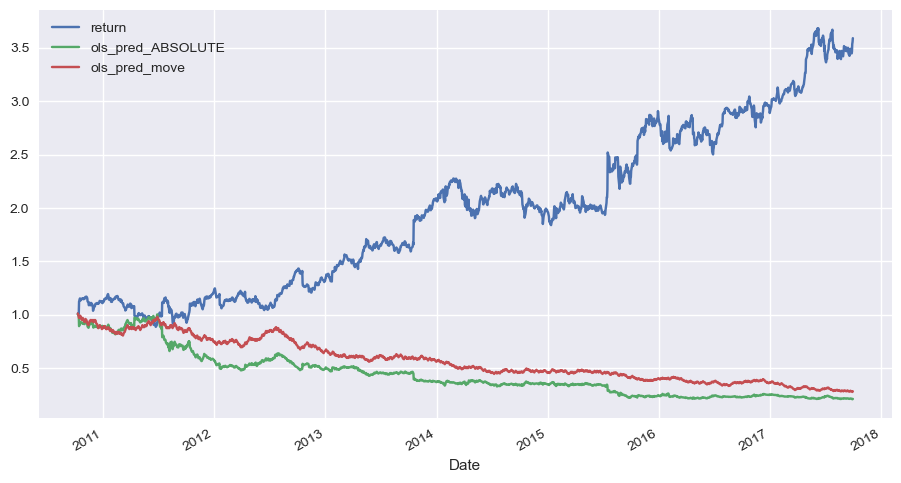

In [45]:
data[['return', 'ols_pred_ABSOLUTE', 'ols_pred_move']].cumsum().apply(np.exp).plot(figsize=(11, 6));

'ols_pred_ABSOLUTE' and 'ols_pred_move' from std dev do not reproduce the asset price path at all. This plot reveals the **poor** quality of prediction. 

**FINDING**: correct negatives plus false negatives make for a bad prediction. OLS seems to produce a lot of negative predicitons which do not realise.

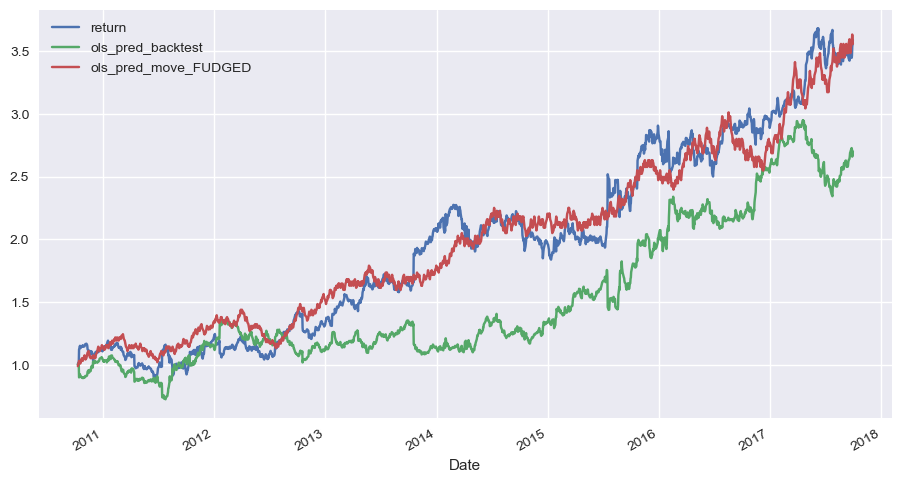

In [46]:
data[['return', 'ols_pred_backtest', 'ols_pred_move_FUDGED']].cumsum().apply(np.exp).plot(figsize=(11, 6));

**INTERIM QUESTIONS**

- Why 'pred_return' does not match the asset path ('return'). 

        ANSWER: because our prediction is not a prediction but Daily Rebalanced P&L, where correctly predicted Negative move results in Positive P&L increment.

    - We have done **worse** than buy and hold: simply investing $100 and holding the position.



- FUDGED inverted sign applied to OLS prediction worked better at reproducing the asset price path. Why is that?

        ANSWER: that's likely because of cancelled false negatives, ie, OLS produces a lot of negative predicitons which do not realise.

Remember OLS is an **invalid** regression model for binary dependent variable {0, 1}. **DO NOT** run OLS in your ML assignments and projects.

## 2. Logistic Classifier (in detail) // Support Vectors (comparison)

In [47]:
from sklearn import linear_model 

from sklearn.svm import SVC  #you can import ANY OTHER CLASSIFIER and proceed in the same way

In [48]:
lm = linear_model.LogisticRegression(C = 1e5) 

svcm = SVC(C = 1e5, probability=True) 

The points below can be considered/have been asked for analysis in an ML Assignment (Exam 3), in the past. 

The one and only hyper-parameter of interest is C, which relates to penalisation or soft/hard margins.

### 2.1 Logistic Classifier
C= 1e5 implies nearly no L2 Penalty because parater set in inverse. Try stronger penalisation C = 0.01 to 0.5

L1 vs L2 type penalty can be investigated but the answer is: impact of L1 penalisation is very strong on zero-ing out the coefficients.

### 2.2 SVM Classifier
C= 1e5 **NOT** inverse for Support Vector Machines. This is Hard Margins.

Prediction with Soft Margins is supposed to work better on time series. Also, SVM requires much selectivity in features choosen because it becomes noticeably slow and because the separability (of classes) is problematic across multiple dimensions (features) at the same time.

## 3. Maximum Likelihood in Binomial Classification (Logistic Classifier/Regression)

Let's find an analytical solution to the maximum likelihood estimation problem for a mix of *independent identically distributed* Bernoulli draws in the regression (prediction) setting.

Each {0,1} outcome has a set of its own explanatory variables $X_i$.

$$y_i|X_i \sim Bernoulli(p_i)$$

$$\mathbb{E}[y_i| X_i] = p_i$$

$$Pr(y_i =1, 0)=\begin{cases} p_i \\ 1-p_i \end{cases}$$

$$f(y_i; p_i) = p_i^{y_i}  (1-p_i)^{1-y_i}$$

Each outcome is determined by the probability of default $p_i$, which is unobserved (latent) in the regression model.

### 3.1 Logistic ML Part 1

The Bernoulli density above translates to the log-likelihood (contribution from one observation i).

$$ logL_i = log f(y_i;p_i) = y_i log\ p_i + (1-y_i) log \ (1-p_i)  $$

The joint log-likelihood for multiple events observed together and treated as independent, is given by the Product Rule of probabilties

$$\begin{equation}\begin{split} log\ f(y_1m y_2, \cdots, y_N) &= log \prod_{i=1}^{N_{obs}} f(y_i;p_i) \\ &= \sum_{i=1}^{N_{obs}}log f(y_i;p_i)\end{split}\end{equation}$$

$$ log L = \sum_{i=1}^{N_{obs}}  [y_i log p_i + (1-y_i) log(1-p_i)]  $$

$y_i$ is known from dataset.

$p_i$ requires inverse of the link, $p_i = g^{-1} (X_i \beta')$

### 3.2 Logistic ML Part 2

We can express Bernoulli density for a random variable $y= {1,0}$ in a more canonical form -- as a member of the Exponential family of distributions.

$$ f(y;p) = p^y (1-p)^{1-y} = exp\bigg[ y\  log(p) + (1-y)\ log(1-p) \bigg]$$

Choice of a link function is $\underline{\text{the same for any categorical Y}}$

$$ g(p) = log(\frac{p}{1-p}) $$

This is a logit function (different from logistic function!), which can be read as the ``log of odds''. The inverse of logit function is logistic function, which we are interested in.

$$ p=\frac{1}{1+e^{-g}} $$

## Under the hood: the choice of Link Function

To adapt the linear regression to non-linear output variable $y_i = 0,1$ or Binomial $y_i = 0,1,2,3,4,\cdots$ or in general case to probability we introduce a non-linear link funciton $y= g(p)$

$$\text{Dependent Variable} = \text{Link Function (Probability)}$$

$$ \begin{equation}\begin{split} 
Y &= X \beta + \epsilon \\
PD \equiv \mathbb{E}[Y|X] &= X \beta \\
g(p) &= X \beta \quad and \\
p&=g(X\beta)^{-1}
\end{split}\end{equation} $$

$$\text{Dependent Variable} = \text{Inverse Link Function (Dependent Variable)}$$

- This covers default/no default $y_i = {1,0}$ and ordinal ratings $y_i = 1,2,3,4,5$. In fact, response variable $Y$ can have any distribution from Exponential family (quasi MLE).
- Linear part $\beta X$ is linked to a non-linear, latent varaible (probability).

$$ p=g(X\beta)^{-1} $$

A link function is the clever bit that allows to convert a categorical event indicator $y_i = {1,0}$ to the probability $p_i$,

$$ p_i = g^{-1} (X_i \beta)$$

$$ \begin{pmatrix} y_1 \\ \vdots \\ y_n\end{pmatrix} \Rightarrow  \begin{pmatrix} g(X_1 \beta)^{-1} \\ \vdots \\ g(X_n \beta)^{-1}\end{pmatrix} \Rightarrow  \begin{pmatrix} Prob_1 \\ \vdots \\ Prob_n\end{pmatrix}$$

Let's make a step forward and say that the inverse of our link will be the **logistic sigmoid function**,

$$ p=\frac{1}{1+e^{-X\beta}}  = \frac{e^{X\beta}}{1+e^{X\beta}}$$

In [49]:
# use data_adv copy of the dataset

lm.fit(data_adv[cols], data_adv['return_sign'])

LogisticRegression(C=100000.0)

In [50]:
%%time
svcm.fit(data_adv[cols], data_adv['return_sign'])

CPU times: total: 2min 9s
Wall time: 11min 54s


SVC(C=100000.0, probability=True)

In [51]:
def logistic_sigmoid(xb):
    return (1 / (1 + np.exp(-xb)))

In [52]:
#Procedure RELIES X_Features, Y_Response variables to be existing
def logistic_plot(X_min, X_max, FeatureName, FeatureBetaIdx):  
    
    plt.clf() #clears the figure drawing space, nothing to do with classifier!
    fig, ax = plt.subplots(figsize=(18,10))  #fig = plt.figure(figsize=(18,10))
        
    # 1. Plot two clusters of observations at Y={-1,1} on a scatter
    ax.scatter(data_adv[FeatureName], data_adv['logit_pred'], c=(data_adv['logit_pred']), zorder=20) #X_Features[FeatureName].ravel()
    
    # 2. Plot CALIBRATED sigmoid function -- with the correctly picked coeffient from Logistic Regression
    X_Sim = np.linspace(X_min, X_max, 100) #fill in values for the range of Axe X
    Y_Loss = logistic_sigmoid(X_Sim * lm.coef_[0,FeatureBetaIdx] + lm.intercept_) 
    # Y_Loss = logistic_sigmoid(X_Sim * logit.coef_[0,FeatureBetaIdx] + logit.intercept_).ravel() 
    ax.plot(X_Sim, Y_Loss, color='red', linewidth=3) # plot sigmoid in Red
      
    plt.ylabel('Beta coeff value for sigmoid: -6.138', fontsize=22) # also ax.set_ylabel('Default Indicator')
    plt.xlabel('w.r.t. Feature: ' + FeatureName, fontsize=22)
    plt.xticks(np.linspace(X_min, X_max, num=10), fontsize=14)
    plt.yticks([-1, 1], fontsize=14)
    plt.ylim(-1.1, 1.1)
    plt.xlim(X_min, X_max) #Axe X range
    plt.legend(('Logistic Regression',),
           loc="lower right", fontsize=14)
    #plt.show()
    return ax

In [53]:
data_adv['logit_pred'] = lm.predict(data_adv[cols])
data_adv['logit_pred_backtest'] = data_adv['return'] * data_adv['logit_pred']

data_adv['svm_pred'] = svcm.predict(data_adv[cols])
data_adv['svm_pred_backtest'] = data_adv['return'] * data_adv['svm_pred'] 

In [54]:
data_adv.head(20)

,return,ret_1,ret_2,ret_3,ret_4,ret_5,return_sign,logit_pred,logit_pred_backtest,svm_pred,svm_pred_backtest
Date,,,,,,,,,,,
2010-10-11,0.004632,0.011891,-0.008155,-0.007235,0.029948,-0.006241,1.0,1.0,0.004632,1.0,0.004632
2010-10-12,0.004721,0.004632,0.011891,-0.008155,-0.007235,0.029948,1.0,1.0,0.004721,1.0,0.004721
2010-10-13,0.003522,0.004721,0.004632,0.011891,-0.008155,-0.007235,1.0,1.0,0.003522,1.0,0.003522
2010-10-14,-0.004372,0.003522,0.004721,0.004632,0.011891,-0.008155,-1.0,1.0,-0.004372,-1.0,0.004372
2010-10-15,0.106054,-0.004372,0.003522,0.004721,0.004632,0.011891,1.0,1.0,0.106054,-1.0,-0.106054
2010-10-18,0.026676,0.106054,-0.004372,0.003522,0.004721,0.004632,1.0,1.0,0.026676,1.0,0.026676
2010-10-19,-0.016124,0.026676,0.106054,-0.004372,0.003522,0.004721,-1.0,1.0,-0.016124,-1.0,0.016124
2010-10-20,0.000247,-0.016124,0.026676,0.106054,-0.004372,0.003522,1.0,-1.0,-0.000247,1.0,0.000247
2010-10-21,0.006574,0.000247,-0.016124,0.026676,0.106054,-0.004372,1.0,-1.0,-0.006574,1.0,0.006574


<Axes: xlabel='w.r.t. Feature: ret_3', ylabel='Beta coeff value for sigmoid: -6.138'>

<Figure size 800x550 with 0 Axes>

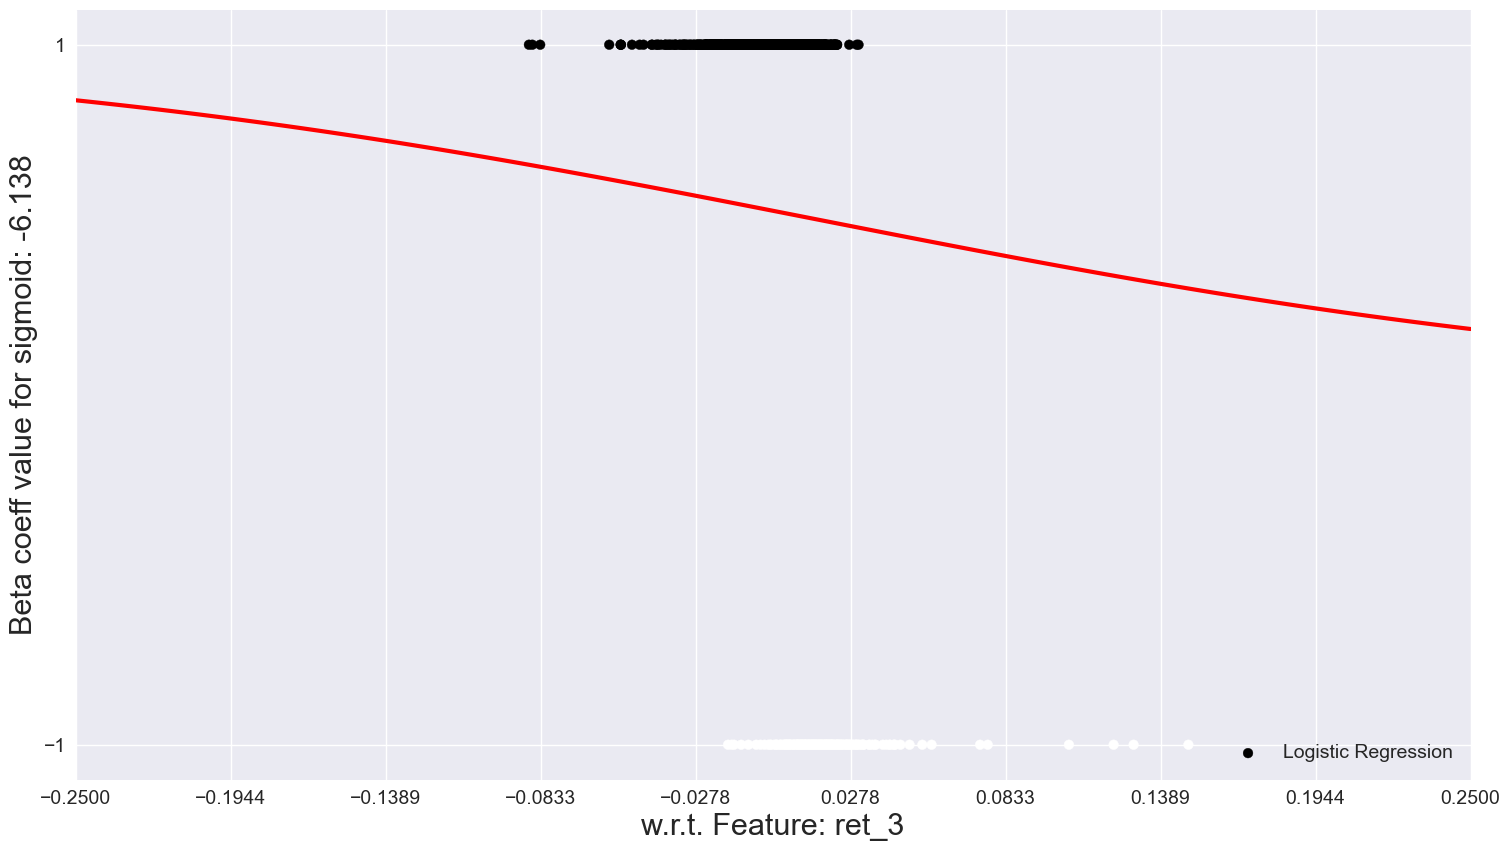

In [55]:
# Error message below will remain due to difference in data types passed into the plotting routine.
# TypeError: 'float' object cannot be interpreted as an integer

logistic_plot(-0.25, 0.25, 'ret_3', 2)

# 'ret_1' has lm.coef_[0,0]

# 'ret_3' has lm.coef_[0,2], the coefficient for ou

Above plot implements the inverse of our link will be the logistic sigmoid function,

$$  p=\frac{1}{1+e^{-X\beta'}}$$

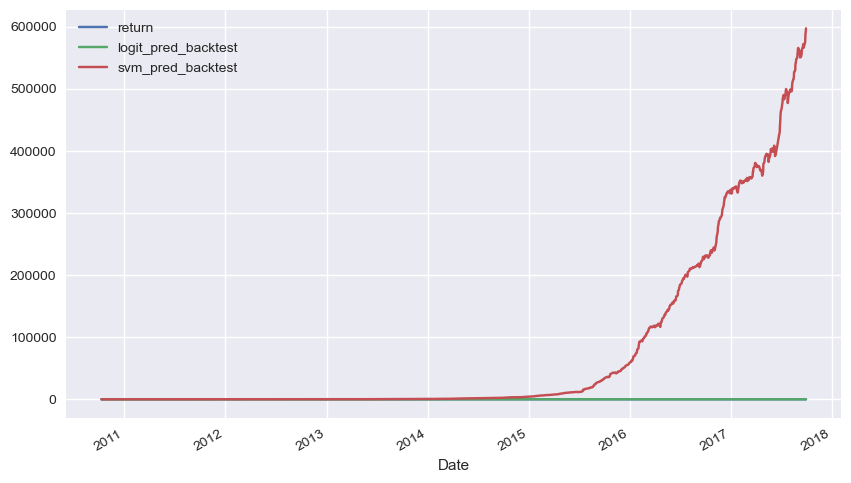

In [56]:
data_adv[['return', 'logit_pred_backtest', 'svm_pred_backtest']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [57]:
# Instead of 0.7 we should use simulated Normal Random Variable
#or we end up with just gives exponentially rising plots, no down moves predicted

#data_adv['logit_pred_move'] = 0.7 * stdev * (data_adv['logit_pred'])
#data_adv['svm_pred_move'] = 0.7 * stdev * (data_adv['svm_pred'])

### Further Steps

Do not rush to a quick conclusion as to which is better Logistic Classifer/SVM/Decision Tree Regressor. That would be dependent on data history, frequency, historical regime (eg high volatility) and the model itself. SVM estimation with more than 2-3 features becomes very slow.
Consider the accuracy and pattern of prediction within each class. This is necessary and can be done in the form of:

1) common tools to check the output of classifiers: **confusion matrix and area under the ROC curve**;

2) investigating the Recall for negative moves, ie, False Negatives problem.

Rethink of advantages and disadvantages of moving onto multinomial classification $\{ -1,0,1 \}$
. For example what would you do if most of observations (daily return) will fall into category of 'no move'.


## More Features from Price Information

Below is an initial set of features, which econometricans typically utilise, and a good starting-level textbook is Forecasting Methods and Applications by Hyndman, Makridakis, and Wheelwright. They dilligently consider lags, each relevant test such as F-statistic, ARIMA and how to implement seasonality. However that is typical econometrics aimed at quarterly, cyclically-dependent indicators such as GDP.

It is possible to get professional and utilise a Python wrapper for something like [TA-Lib](https://github.com/TA-Lib/ta-lib-python). However, we would like to be able to compupte technical analysis indicators from the first princiles, whenever possible.

There are also a variety of estimators for volatility, which unlilike the EWMA and GARCH -- focus on capturing the realised variance and the ghi -- some you are very familiar with, such as EWMA and GARCH, however

In [58]:
def createFeatures(df):
    '''
    Below code features to an existing data frame
    '''
#    df = df.rename(columns={df.columns[0]: 'price'})
#    df['return'] = df.pct_change()
#    df['log_return'] = np.log(df['price']/df['price'].shift(periods=1))
#    df['sign'] = df['log_return'].apply(lambda x: 0 if x<0 else 1)
    df['return_1d']= df['return'].shift(periods=1)
    df['return_2d']= df['return'].shift(periods=2)
    df['return_5d']= df['return'].shift(periods=5)
    df['momentum_1d']=df['price']-df['price'].shift(periods=1)
    df['momentum_2d']=df['price']-df['price'].shift(periods=2)
    df['momentum_5d']=df['price']-df['price'].shift(periods=5)
    df['MA_5d']=df['price'].rolling(5).mean()
    df['MA_10d']=df['price'].rolling(10).mean()
    df['MA_20d']=df['price'].rolling(20).mean()
    df['MA_50d']=df['price'].rolling(50).mean()
    df['EMA_5d']=df['price'].ewm(5, adjust=False).mean()
    df['EMA_10d']=df['price'].ewm(10, adjust=False).mean()
    df['EMA_20d']=df['price'].ewm(20, adjust=False).mean()
    df['EMA_50d']=df['price'].ewm(50, adjust=False).mean()
    return df